# Rep Guide using MediaPipe

In [2]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [3]:
# For webcam input:
cap = cv2.VideoCapture('KneeBendVideo.mp4')
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)
    landmarks = results.pose_landmarks.landmark

    # Draw the pose annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Pose', image)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### Looking at all the landmarks

![Landmarks](https://camo.githubusercontent.com/37bc1d0f546f2dd001798a0f66057c9c907e6b5efae95a068bcce8c852c2e234/68747470733a2f2f692e696d6775722e636f6d2f336a38425064632e706e67)

Let us look what a landmark looks like

In [4]:
landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].visibility

0.9983614087104797

In [5]:
landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]

x: 0.603471040725708
y: 0.7506308555603027
z: -0.1929214596748352
visibility: 0.8054438233375549

In [6]:
landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]

x: 0.5070220828056335
y: 0.7888687252998352
z: -0.10971036553382874
visibility: 0.5526841282844543

### Coming to the assignment use-case

Exercise description -  
<ol>
    <li> Leg should be bent to start timer</li>
    <li> Slight inward bend is enough to start the timer. ( <140 deg)</li>
    <li> After a successful rep, the person has to stretch his/her leg straight.</li>
    <li> No restriction for back angle</li>
    <li> Consider leg closer to camera as exercised leg </li>
</ol>


From the above description and from the video shared , it is clear that we primarily need to focus on the left leg of the person in the frame

To calculate the the angle that the leg and the ankle is making, we would require the following landmarks
   <ol>
    <li> left_hip</li>
    <li>left_knee</li>
    <li>left_ankle</li>
  </ol>

Now, we will be only taking the x and y co-ordinates of these landmarks since, taking z won't be much benificial and also, it  would add up to more complexities 

In [9]:
hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

In [10]:
hip, knee, ankle

([0.6445006728172302, 0.8251363635063171],
 [0.4404439330101013, 0.8205329179763794],
 [0.3819670081138611, 0.8452469706535339])

## Calculating Angles

### Logic to calculate anngles

let us consider the 2 vecotors 

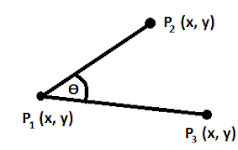

let p2 = hip, p1 = knee and p3 = ankle

now, we have to calculate angle theta!

let us consider the 2 lines 
so slope = tan(theta) = y2-y1/x2-x1
applying the smae

In [11]:
import numpy as np
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [14]:
angle = calculate_angle(hip, knee, ankle)
angle

155.797311235883